<a href="https://colab.research.google.com/github/kohathyli/Credeit-Default/blob/main/DURF_Classification_%2B_Time_Series_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.display import SVG, display
from graphviz import Source
from mlxtend.plotting import plot_decision_regions
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
df = pd.read_csv("default of credit card clients.csv")

In [8]:
df.rename(columns={"PAY_0": "PAY_1"}, inplace=True)
df.drop('ID', axis = 1, inplace =True)
df["default payment next month"] = df["default payment next month"].astype('category')

In [9]:
df.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_1                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   LIMIT_BAL                   30000 non-null  int64   
 1   SEX                         30000 non-null  int64   
 2   EDUCATION                   30000 non-null  int64   
 3   MARRIAGE                    30000 non-null  int64   
 4   AGE                         30000 non-null  int64   
 5   PAY_1                       30000 non-null  int64   
 6   PAY_2                       30000 non-null  int64   
 7   PAY_3                       30000 non-null  int64   
 8   PAY_4                       30000 non-null  int64   
 9   PAY_5                       30000 non-null  int64   
 10  PAY_6                       30000 non-null  int64   
 11  BILL_AMT1                   30000 non-null  int64   
 12  BILL_AMT2                   30000 non-null  int64   
 13  BILL_AMT3       

In [11]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [12]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [13]:
df['MARRIAGE']=np.where(df['MARRIAGE'] == 0, 3, df['MARRIAGE'])

df['EDUCATION']=np.where(df['EDUCATION'] == 5, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 6, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 0, 4, df['EDUCATION'])

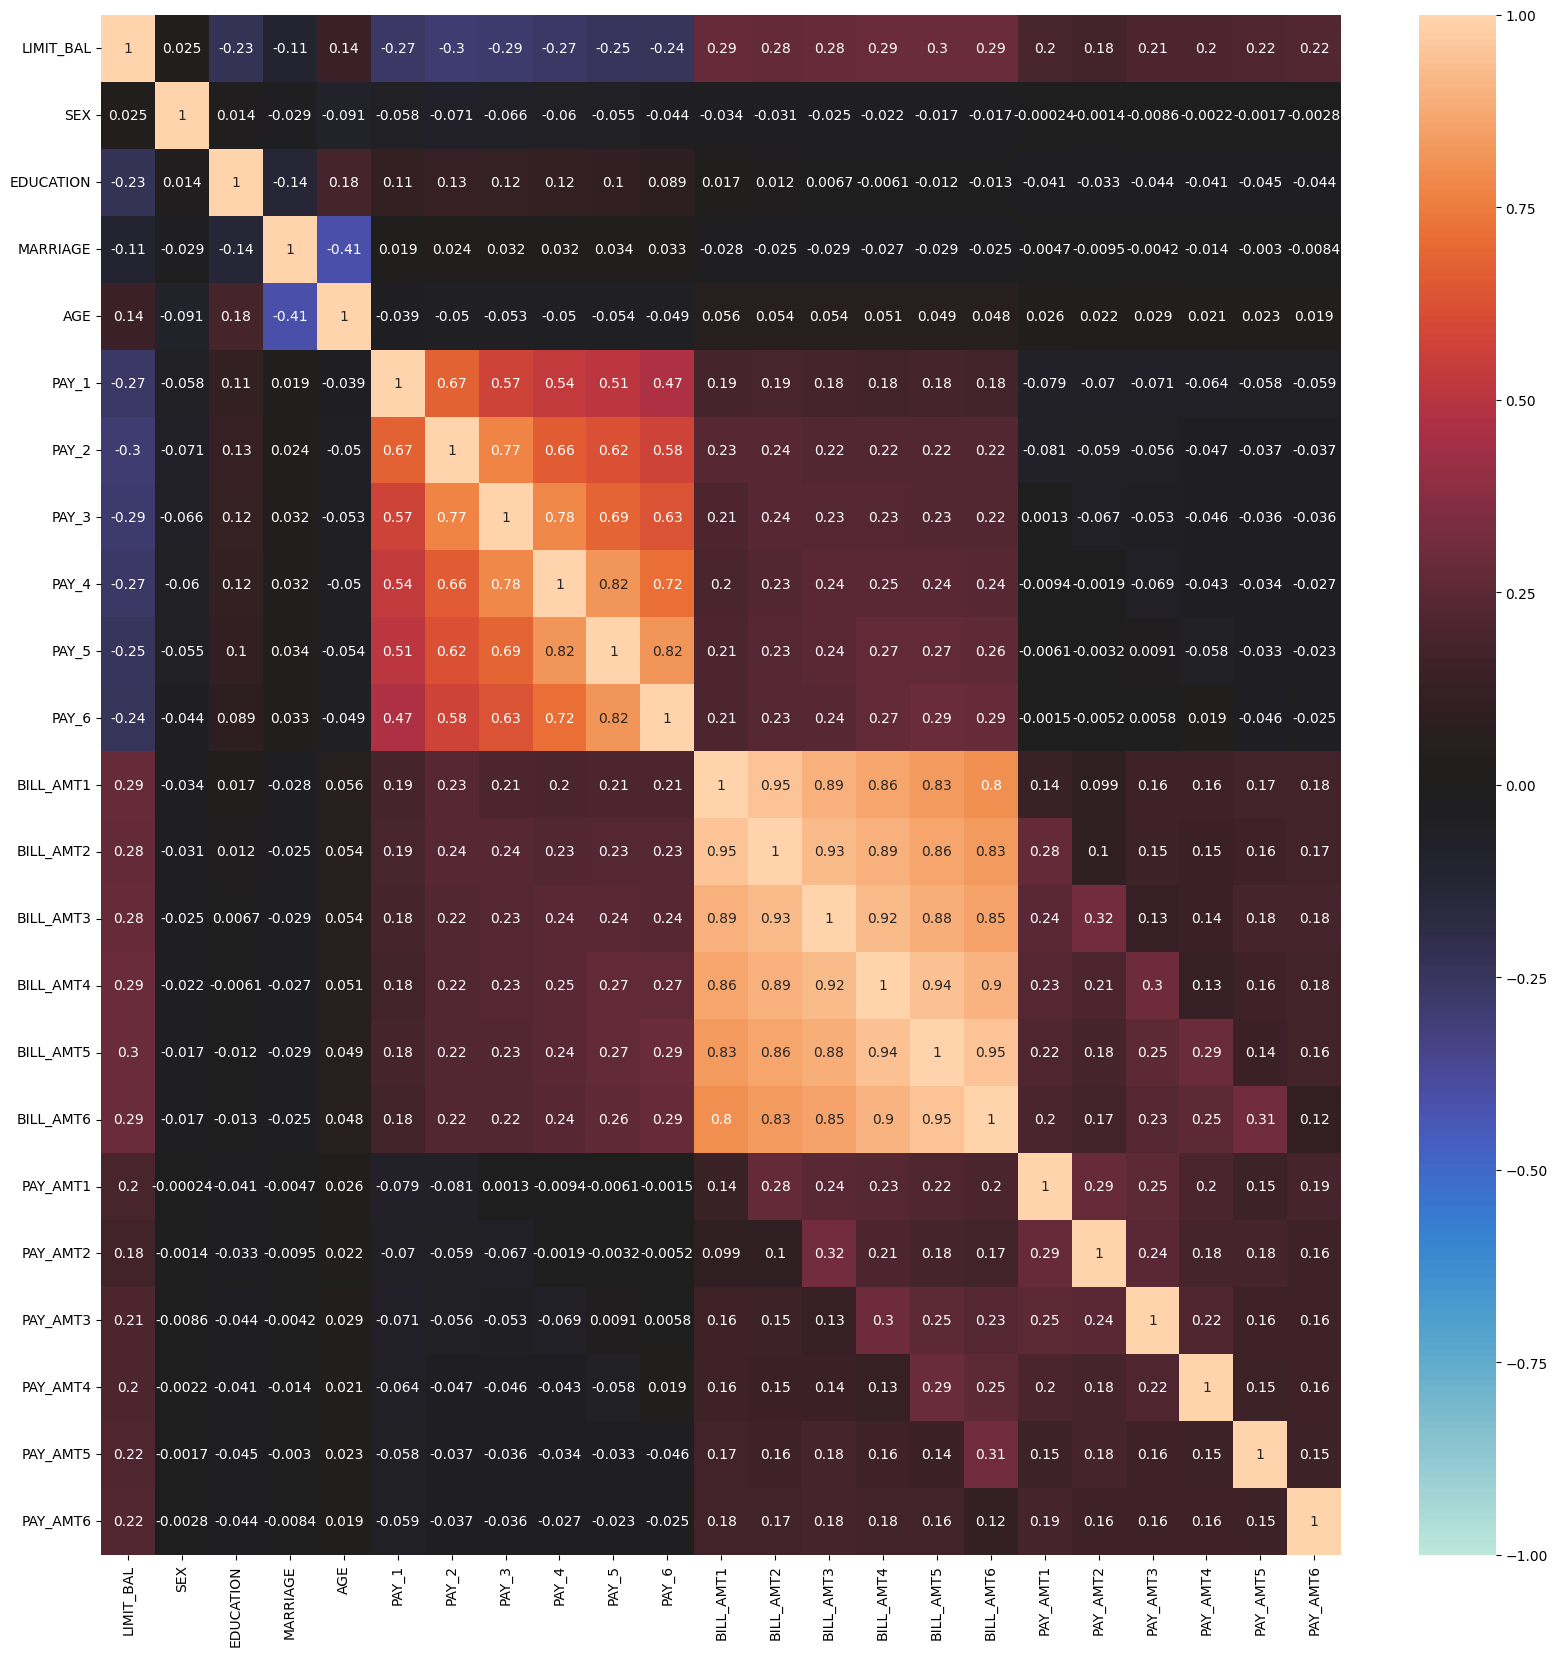

In [14]:
df_corr_y = df.copy()
plt.figure(figsize = (20,20))
sns.heatmap(df_corr_y.corr(), vmin=-1, vmax=1, center=0, annot=True)
plt.show()

In [15]:
numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [16]:
data_num = df[numeric]

#scale on numerical columns--brings the value of each feature into the range of 0 to 1
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
def scaleNum(df_num, cols):
    for col in cols:
        df_num[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(data_num[col])),columns=[col])
    return df_num
data_normal_num = scaleNum(data_num,data_num.columns)
data_normal_num.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.010101,0.051724,0.149982,0.069164,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.111111,0.086207,0.148892,0.067858,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.080808,0.224138,0.172392,0.079532,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,0.275862,0.188100,0.111995,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,0.620690,0.154144,0.071601,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284


In [17]:
for att in ['SEX', 'EDUCATION', 'MARRIAGE']:
  df[att] = df[att].astype('category')

df=pd.concat([pd.get_dummies(df['SEX'], prefix='SEX'),
                pd.get_dummies(df['EDUCATION'], prefix='EDUCATION'),
                pd.get_dummies(df['MARRIAGE'], prefix='MARRIAGE'),
                df],axis=1)
# drop original columns
df.drop(['EDUCATION'],axis=1, inplace=True)
df.drop(['SEX'],axis=1, inplace=True)
df.drop(['MARRIAGE'],axis=1, inplace=True)

df.head()

,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0,1,0,1,0,0,1,0,0,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,0,1,0,1,0,0,0,1,0,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,0,1,0,1,0,0,0,1,0,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0,1,0,1,0,0,1,0,0,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,1,0,0,1,0,0,1,0,0,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [18]:
y = df['default payment next month']
X = df.drop('default payment next month', axis = 1, inplace = False)

In [19]:
# Check data set dimension
print(X.shape)
print("Number of samples:", X.shape[0])
print("Number of attributes:", X.shape[1])

(30000, 29)
Number of samples: 30000
Number of attributes: 29


In [20]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [21]:
FEATURE_SELECTION = False
corr = df[numeric].corr()

if FEATURE_SELECTION :
    # remove features with correlation coefficent >= 0.93
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.92)]
    print(to_drop) #['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
    df= df.drop(df[to_drop], axis = 1)

In [22]:
over = SMOTE(sampling_strategy=0.5)

steps = [
    ('over',over)
]
xs, ys = Pipeline(steps=steps).fit_resample(X_train, y_train)
class_cnt = dict(Counter(ys))
print('The new count of classes:', class_cnt)

The new count of classes: {0: 18691, 1: 9345}


In [23]:
model_rfgi = RandomForestClassifier(criterion='gini')
model_rfgi.fit(xs, ys)

RandomForestClassifier()

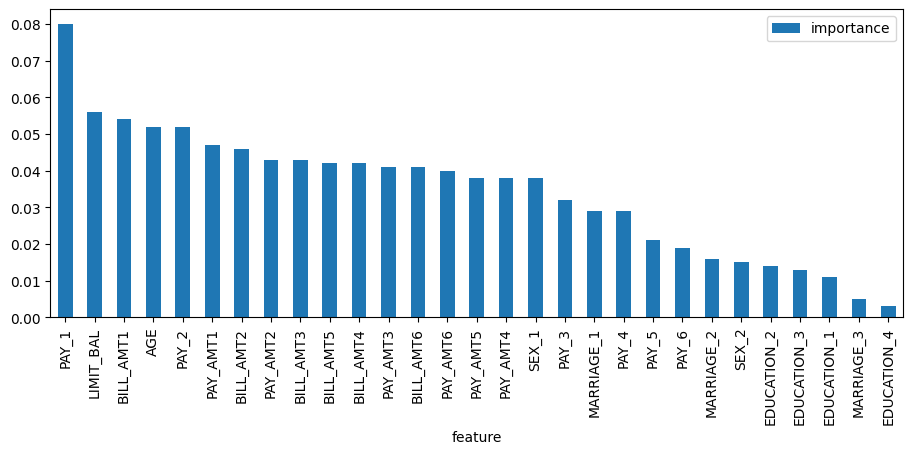

In [24]:
score = np.round(model_rfgi.feature_importances_,3)
importances = pd.DataFrame({'feature':xs.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [25]:
model_gb = GradientBoostingClassifier()
model_gb.fit(xs, ys)

GradientBoostingClassifier()

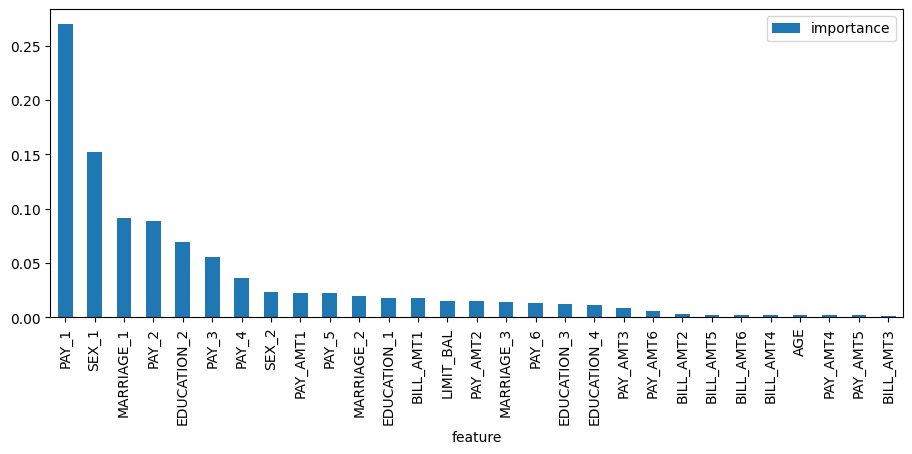

In [26]:
model_gb.fit(xs, ys);
# extract important features
score = np.round(model_gb.feature_importances_,3)
importances = pd.DataFrame({'feature':xs.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [27]:
X = xs.append(X_test)
y = ys.append(y_test)

In [28]:
X.values
y.values

[0, 0, 0, 1, 0, ..., 0, 0, 0, 0, 0]
Length: 34036
Categories (2, int64): [0, 1]

In [29]:
rfgi_tuned_params = {   "max_depth": sp_randint(1, 4),
                      "min_samples_leaf"  : sp_randint(2, 11),
                      'min_samples_split' : sp_randint(2, 11)}
n_iter_search = 20
random_search = RandomizedSearchCV(model_rfgi, rfgi_tuned_params,
                                   n_iter = n_iter_search, cv=10)

random_search.fit(X, y)
print("Best Params : ",random_search.best_params_,"\n")
best_rfgi = random_search.best_params_

means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, random_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best Params :  {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 10} 

0.750 (+/-0.011) for {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 3}
0.741 (+/-0.010) for {'max_depth': 2, 'min_samples_leaf': 9, 'min_samples_split': 6}
0.751 (+/-0.009) for {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 6}
0.750 (+/-0.012) for {'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 3}
0.725 (+/-0.008) for {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 6}
0.743 (+/-0.009) for {'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 6}
0.724 (+/-0.008) for {'max_depth': 1, 'min_samples_leaf': 8, 'min_samples_split': 7}
0.724 (+/-0.005) for {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 6}
0.742 (+/-0.009) for {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 3}
0.751 (+/-0.008) for {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 10}
0.723 (+/-0.004) for {'max_depth': 1, 'min_samples_leaf': 10, 'min_

In [30]:
model_rfgi2 = RandomForestClassifier(criterion='gini', max_depth= best_rfgi['max_depth'], min_samples_leaf= best_rfgi['min_samples_leaf'], min_samples_split= best_rfgi['min_samples_split'])

In [31]:
model_rfgi2.fit(xs, ys)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=10)

In [32]:
model_rfgi2.predict(X_test)
model_rfgi2.score(X_test,y_test)

0.8021666666666667

In [33]:
rfgiprob = model_rfgi2.predict_proba(X_test)
rfgipredprob = pd.DataFrame({"probabilities":list(rfgiprob)})

In [34]:
X_testdf = pd.DataFrame(X_test, columns = X.columns)

In [35]:
X_testdf['RFGIPROBABILITIES'] = rfgipredprob.values
X_testdf[['RFGI_PROB_NONDEFAULT','RFGI_PROB_DEFAULT']] = pd.DataFrame(X_testdf.RFGIPROBABILITIES.values.tolist(), index= X_testdf.index)
X_testdf.drop(['RFGIPROBABILITIES'], axis = 1, inplace=True)

In [36]:
gb_tuned_params = {   "max_depth": sp_randint(1, 4),
                      "min_samples_leaf"  : sp_randint(2, 11),
                      'min_samples_split' : sp_randint(2, 11)}
# you can change it
n_iter_search = 20
random_search = RandomizedSearchCV(model_gb, gb_tuned_params,
                                   n_iter = n_iter_search, cv=5)

random_search.fit(X, y)
print("Best Params : ",random_search.best_params_,"\n")
best_gb = random_search.best_params_

means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, random_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best Params :  {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 8} 

0.810 (+/-0.073) for {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.761 (+/-0.009) for {'max_depth': 1, 'min_samples_leaf': 7, 'min_samples_split': 7}
0.761 (+/-0.009) for {'max_depth': 1, 'min_samples_leaf': 6, 'min_samples_split': 8}
0.810 (+/-0.075) for {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 6}
0.826 (+/-0.112) for {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 3}
0.761 (+/-0.009) for {'max_depth': 1, 'min_samples_leaf': 6, 'min_samples_split': 8}
0.761 (+/-0.009) for {'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 6}
0.809 (+/-0.073) for {'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 7}
0.809 (+/-0.073) for {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 3}
0.761 (+/-0.009) for {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.761 (+/-0.009) for {'max_depth': 1, 'min_samples_leaf': 5, 'min_sa

In [37]:
model_gb2 = GradientBoostingClassifier(max_depth= best_gb["max_depth"], min_samples_leaf= best_gb["min_samples_leaf"], min_samples_split= best_gb["min_samples_split"])

In [38]:
model_gb2.fit(xs, ys)

GradientBoostingClassifier(min_samples_leaf=8, min_samples_split=8)

In [39]:
model_gb2.score(X_test,y_test)

0.8183333333333334

In [40]:
gbprob = model_gb2.predict_proba(X_test)
gbpredprob = pd.DataFrame({"probabilities":list(gbprob)})

In [41]:
X_testdf['GBPROBABILITIES'] = gbpredprob.values
X_testdf[['GB_PROB_NONDEFAULT','GB_PROB_DEFAULT']] = pd.DataFrame(X_testdf.GBPROBABILITIES.values.tolist(), index= X_testdf.index)
X_testdf.drop(['GBPROBABILITIES'], axis = 1, inplace=True)

In [42]:
def fig_roc(clf,X_train, X_test, y_train, y_test):
    clf.fit(X_train,y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
    fp,tp,thresholds=roc_curve(y_test, y_scores, pos_label=1)
    AUC=auc(fp,tp)*100
    plt.plot(fp, tp, color='blue',label = 'AUC = %0.2f' % AUC)
    t=str(clf)
    plt.title('Receiver Operating Characteristic'+t)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

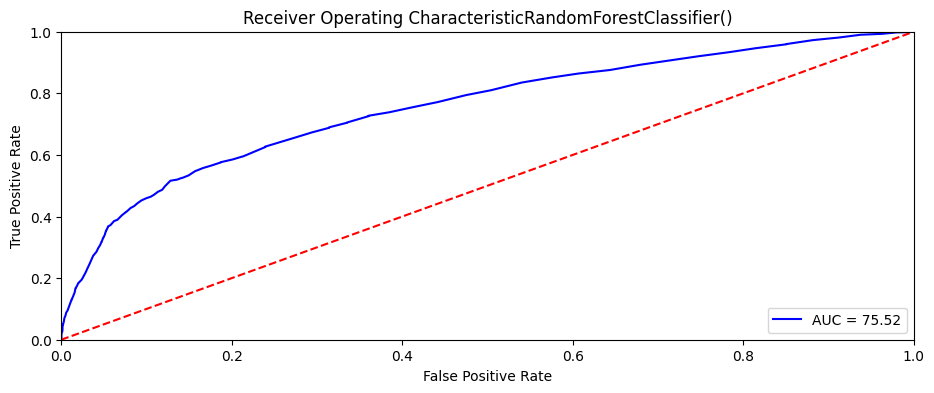

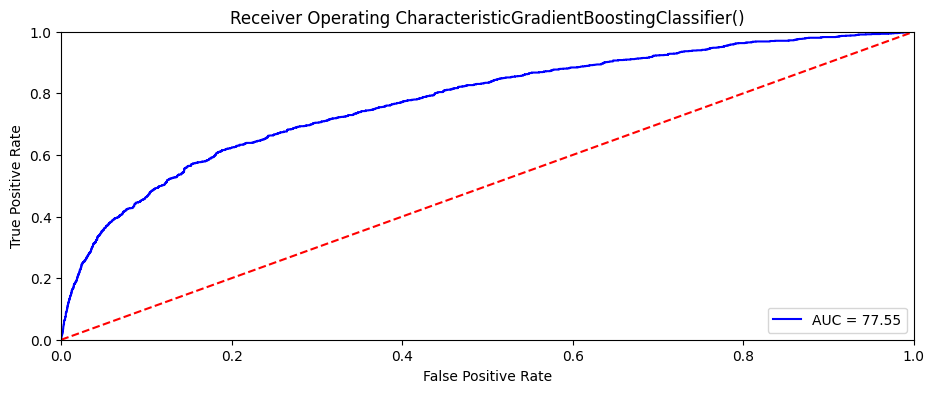

In [43]:
fig_roc(model_rfgi,xs, X_test, ys, y_test)
fig_roc(model_gb,xs, X_test, ys, y_test)

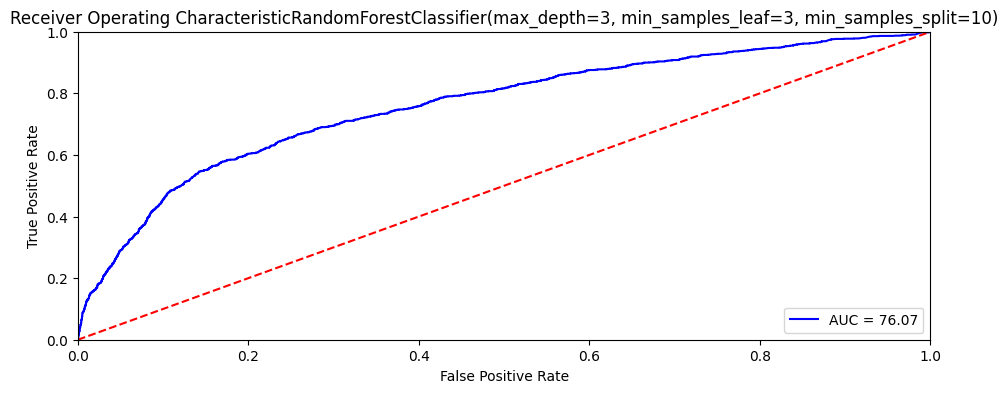

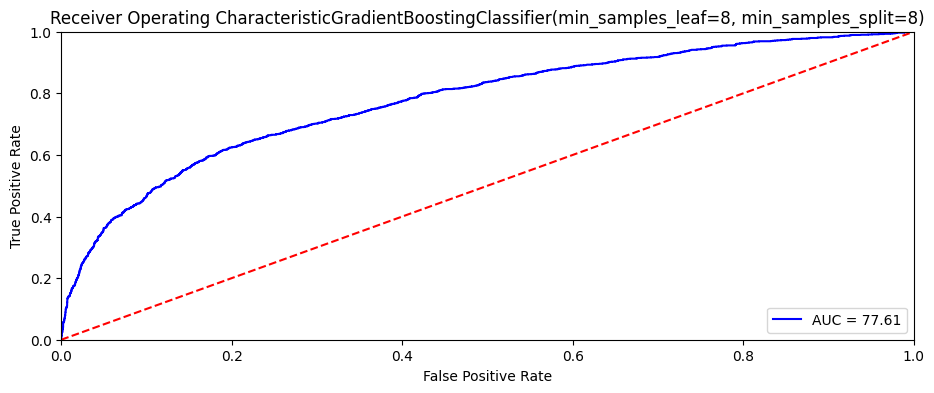

In [44]:
fig_roc(model_rfgi2,xs, X_test, ys, y_test)
fig_roc(model_gb2,xs, X_test, ys, y_test)

In [45]:
rf_probabilities1 = model_rfgi2.predict_proba(X_test)[:, 1]
gb_probabilities1 = model_gb2.predict_proba(X_test)[:, 1]
correlation_coefficient = np.corrcoef(rf_probabilities1, gb_probabilities1)[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: 0.9391992726813391


In [46]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[
    ('rf', model_rfgi2),
    ('gb', model_gb2),
], voting = 'soft')
ensemble_model.fit(xs, ys)
ensemble_predictions = ensemble_model.predict(X_test)

ensemble_score = ensemble_model.score(X_test, y_test)
print("Ensemble Model Score: ", ensemble_score)

Ensemble Model Score:  0.8151666666666667


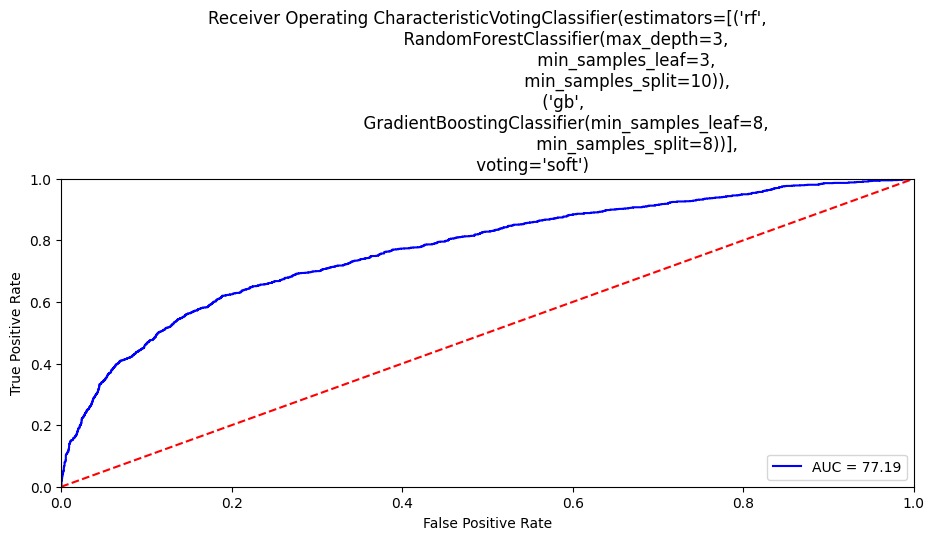

In [47]:
fig_roc(ensemble_model, xs, X_test, ys, y_test)

In [48]:
df['TOTAL_BILL_AMT'] = df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']
df['TOTAL_PAY_AMT'] = df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6']

In [49]:
predict_proba = ensemble_model.predict_proba(X_test)
default_df = df.iloc[X_test.index]
default_df['default payment next month'] = y_test
default_df['DEFAULT_PROBA'] = predict_proba[:,1]
default_df['OUTSTANDING'] = default_df['TOTAL_BILL_AMT'] - default_df['TOTAL_PAY_AMT']
default_df['DEFAULT_IMPORTANCE'] = round(default_df['OUTSTANDING'] * default_df['DEFAULT_PROBA'], 2)
default_df.sort_values(by='DEFAULT_IMPORTANCE', ascending=False)[['DEFAULT_IMPORTANCE']].head(20)

,DEFAULT_IMPORTANCE
15593,1790364.27
7048,1383334.29
22656,1355390.85
9761,1331743.42
1496,1326182.57
214,1316853.24
27221,1311423.53
15316,1299929.86
20992,1293526.95
16519,1288636.12


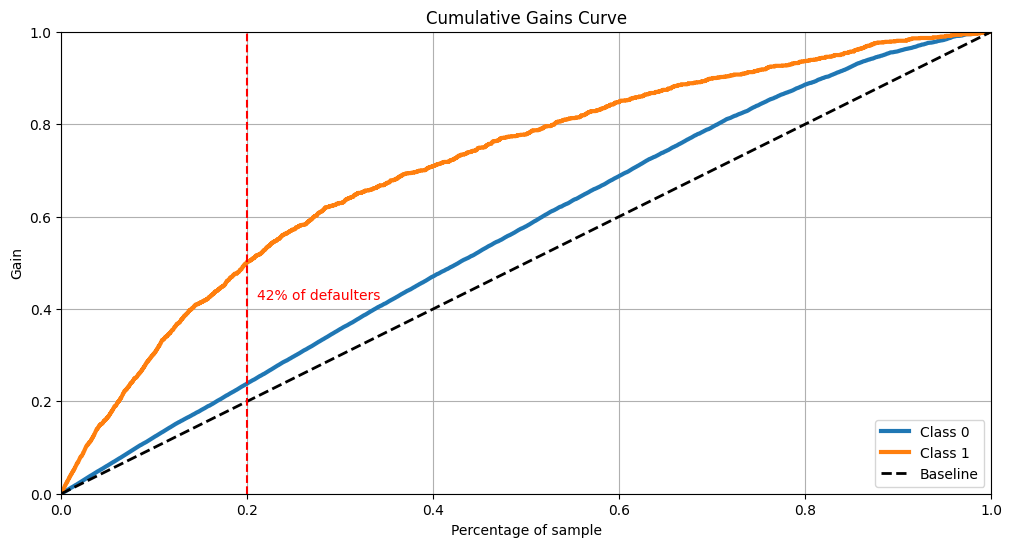

In [50]:
!pip install scikit-plot
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

plot_cumulative_gain(y_test, predict_proba, figsize=(12,6));

# red line to indicate 40% mark
plt.axvline(x=0.2, color='r', linestyle='--')
plt.text(0.21, 0.42, '42% of defaulters', color='r');

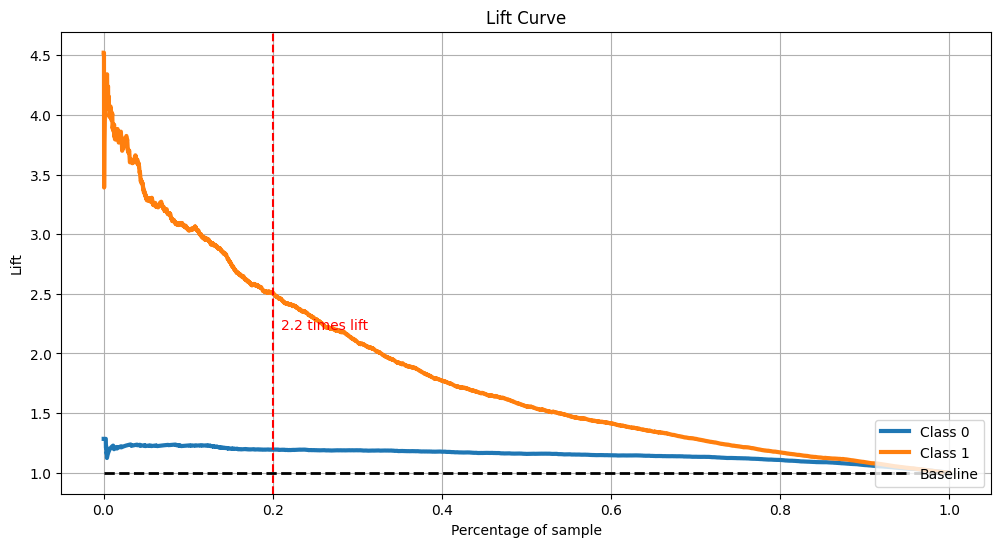

In [51]:
plot_lift_curve(y_test, predict_proba, figsize=(12,6))
plt.axvline(x=0.2, color='r', linestyle='--')
plt.text(0.21, 2.2, '2.2 times lift', color='r');

**Time Series Forcasting**

In [52]:
df_time_series = pd.read_csv("default of credit card clients.csv")
df_time_series.rename(columns={"PAY_0": "PAY_1"}, inplace=True)

In [53]:
def rnn_train_test_split(df, ratio):
    """
    split the train test df based on the ratio, ex: 0.8
    """
    length = len(df)
    idx = int(length*ratio)
    df_train = df.iloc[:idx,:]
    df_test = df.iloc[idx:,:]

    print(df_train.shape)
    print(df_test.shape)

    return df_train, df_test

In [54]:
df_train, df_test = rnn_train_test_split(df_time_series, 0.8)

(24000, 25)
(6000, 25)


In [55]:
def organize_dynamic_feat(df):
    """
    orgainze dynamic features for each ID
    """

    dynamic_features = ['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                        'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                        'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                        'default payment next month']

    #static_features = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE']

    df = df[dynamic_features]

    df_dynamic_all = []
    df_dynamic_label = []

    for row in range(len(df)):
        """
        for each ID
        """
        dynamic_feat_1 = df.iloc[row,0:6]
        dynamic_feat_2 = df.iloc[row,6:12]
        dynamic_feat_3 = df.iloc[row,12:18]
        dynamic_feat_label = df.iloc[row,len(dynamic_features)-1]

        single_data = np.array([dynamic_feat_1, dynamic_feat_2, dynamic_feat_3]).reshape(-1,3)
        single_label = np.array(dynamic_feat_label).reshape(-1,1)

        df_single_data = pd.DataFrame(data=single_data, columns=['PAY','BILL_AMT','PAY_AMT'])
        df_single_data_label = pd.DataFrame(data=single_label, columns=['label'])

        df_dynamic_all.append(df_single_data)
        df_dynamic_label.append(df_single_data_label)

    return df_dynamic_all, df_dynamic_label

In [56]:
df_dynamic_train, df_dynamic_train_label = organize_dynamic_feat(df_train)
df_dynamic_test, df_dynamic_test_label = organize_dynamic_feat(df_test)

In [57]:
import torch
import torch.utils.data as Data

def get_rnn_train_test(df_dynamic_train, df_dynamic_train_label, time_step):
    """
    get the training dataset and testing dataset for rnn
    """

    x_rnn = []
    y_rnn = []

    col_len = 3 # number of dynamice features

    for num in range(len(df_dynamic_train)):
        """
        for each ID
        """
        for row in range(0, len(df_dynamic_train[num])-time_step):
            x_rnn.append(df_dynamic_train[num].iloc[row:(row+time_step),0:(col_len)].values.reshape(len(df_dynamic_train[num].iloc[:,0:(col_len)].columns)*time_step))
            y_rnn.append(df_dynamic_train_label[num].values)


    x_rnn = torch.from_numpy(np.array(x_rnn)).reshape(-1,col_len*time_step,1).type(torch.FloatTensor)
    y_rnn = torch.from_numpy(np.array(y_rnn)).view(-1,1).type(torch.FloatTensor)

    print(x_rnn.shape, y_rnn.shape)
    dataset = Data.TensorDataset(x_rnn, y_rnn)

    return dataset

In [58]:
training_dataset = get_rnn_train_test(df_dynamic_train,
                                      df_dynamic_train_label,
                                      time_step = 4)

testing_dataset = get_rnn_train_test(df_dynamic_test,
                                     df_dynamic_test_label,
                                     time_step = 4)

torch.Size([48000, 12, 1]) torch.Size([48000, 1])
torch.Size([12000, 12, 1]) torch.Size([12000, 1])


In [59]:
training_loader = Data.DataLoader(
    dataset = training_dataset,
    shuffle = True,
    batch_size = 256,
    num_workers = 4,
)

testing_loader = Data.DataLoader(
    dataset = testing_dataset,
    shuffle = True,
    batch_size = 256,
    num_workers = 4,
)

In [60]:
class history_package():
    def __init__(self, neural_net, train_loader, test_loader, EPOCH, LR, model_type):

        self.net = neural_net
        self.optimizer = torch.optim.Adam(neural_net.parameters(), lr = LR)

        pos_weight = torch.tensor([4]).to(device) # solve the imbalance data problem
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        self.train_loader = train_loader
        self.test_loader = test_loader
        self.EPOCH_ = EPOCH
        self.LR_ = LR
        self.net = self.net.to(device)
        self.model_type = model_type

        self.training_acc = []
        self.testing_acc = []

        if device == 'cuda':
            torch.backends.cudnn.benchmark = True

    def start(self):

        train_loss_list = []
        test_loss_list = []

        for epoch in range(self.EPOCH_):

            if epoch % 10 == 0:
                print("============================")
                print('Epoch:', epoch)


            train_loss = self.train(epoch)
            test_loss = self.test(epoch)

            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)

        return train_loss_list, test_loss_list, self.training_acc, self.testing_acc

    def train(self, epoch):

        self.net.train()
        train_loss = 0
        correct = 0
        total = 0


        for step, (batch_X, batch_y) in enumerate(self.train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            self.optimizer.zero_grad()
            outputs = self.net(batch_X)


            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()

            predicted = (outputs >= 0.5)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()

        self.training_acc.append(100.*(correct/total))

        if epoch % 10 == 0:
            print('【Training】Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss, 100.*(correct/total), correct, total))

        # save the model

        #if self.model_type == "LSTM":
            #torch.save(self.net.state_dict(), './model/LSTM_model.pth')

        #if self.model_type == "LSTM_pos_weight":
            #torch.save(self.net.state_dict(), './model/LSTM_model_pos_weight.pth')


        return train_loss

    def test(self, epoch):

        self.net.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for step, (batch_X, batch_y) in enumerate(self.test_loader):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = self.net(batch_X)

                loss = self.criterion(outputs, batch_y)

                test_loss += loss.item()

                predicted = (outputs >= 0.5)
                total += batch_y.size(0)
                correct += predicted.eq(batch_y).sum().item()

        self.testing_acc.append(100.*(correct/total))

        if epoch % 10 == 0:
            print('【Testing】Loss: %.3f | Acc: %.3f%% (%d/%d)' % ( test_loss, 100.*(correct/total), correct, total ))


        return test_loss

In [61]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x, None)
        out = self.fc(out[:, -1, :])
        prob = F.sigmoid(out)

        return prob

In [62]:
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn.functional as F
#from tensorflow.keras.layers import LSTM
import torch.nn as nn

start_time = time.time()

rnn_module = history_package(LSTM(input_dim=1,
                                  hidden_dim=512,
                                  num_layers=3,
                                  output_dim=1),
                             training_loader,
                             testing_loader,
                             EPOCH=100,
                             LR=0.0001,
                             model_type = "LSTM_pos")

history_train_loss, history_test_loss, history_train_acc, history_test_acc = rnn_module.start()

end_time = time.time()
print('Training Time Cost: ',time.strftime("%H hr %M min %S sec", time.gmtime(end_time - start_time)))

Epoch: 0
【Training】Loss: 207.054 | Acc: 77.646% (37270/48000)
【Testing】Loss: 48.951 | Acc: 80.933% (9712/12000)
Epoch: 10
【Training】Loss: 198.050 | Acc: 77.533% (37216/48000)
【Testing】Loss: 48.391 | Acc: 79.608% (9553/12000)
Epoch: 20
【Training】Loss: 197.788 | Acc: 77.479% (37190/48000)
【Testing】Loss: 48.363 | Acc: 79.275% (9513/12000)
Epoch: 30
【Training】Loss: 197.653 | Acc: 77.442% (37172/48000)
【Testing】Loss: 48.331 | Acc: 79.425% (9531/12000)
Epoch: 40
【Training】Loss: 197.452 | Acc: 77.669% (37281/48000)
【Testing】Loss: 48.252 | Acc: 79.325% (9519/12000)
Epoch: 50
【Training】Loss: 197.121 | Acc: 77.825% (37356/48000)
【Testing】Loss: 48.333 | Acc: 79.667% (9560/12000)
Epoch: 60
【Training】Loss: 197.192 | Acc: 77.542% (37220/48000)
【Testing】Loss: 48.281 | Acc: 79.167% (9500/12000)
Epoch: 70
【Training】Loss: 196.654 | Acc: 77.829% (37358/48000)
【Testing】Loss: 48.302 | Acc: 79.408% (9529/12000)
Epoch: 80
【Training】Loss: 196.286 | Acc: 78.071% (37474/48000)
【Testing】Loss: 48.309 | Acc: 79.33

Text(0.5, 1.0, 'Training Acc')

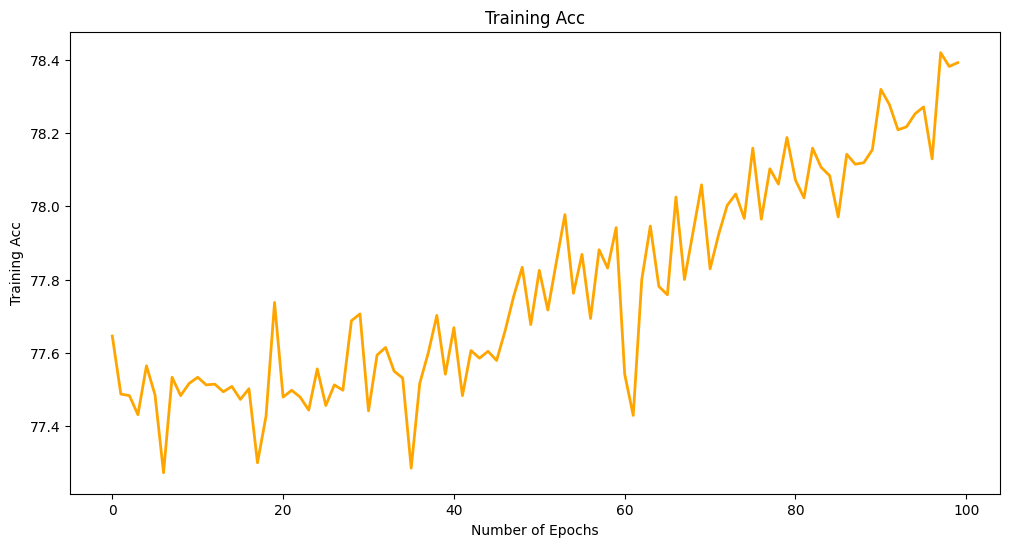

In [64]:
plt.figure(figsize=(12,6))
plt.plot(history_train_acc, color='orange', lw=2)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Acc")
plt.title("Training Acc")

Text(0.5, 1.0, 'Testing Acc')

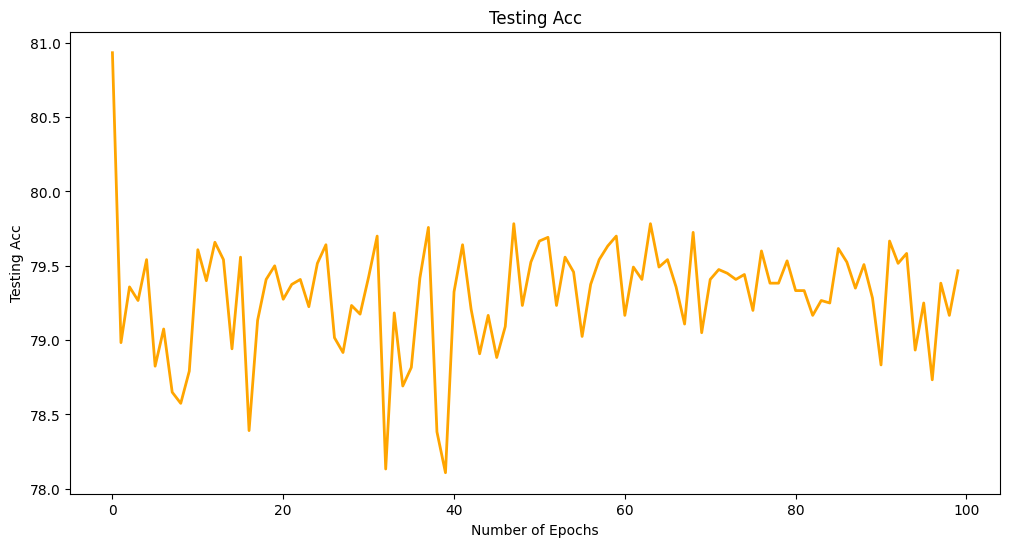

In [65]:
plt.figure(figsize=(12,6))
plt.plot(history_test_acc, color='orange', lw=2)
plt.xlabel("Number of Epochs")
plt.ylabel("Testing Acc")
plt.title("Testing Acc")

Text(0.5, 1.0, 'LSTM Learning Curve')

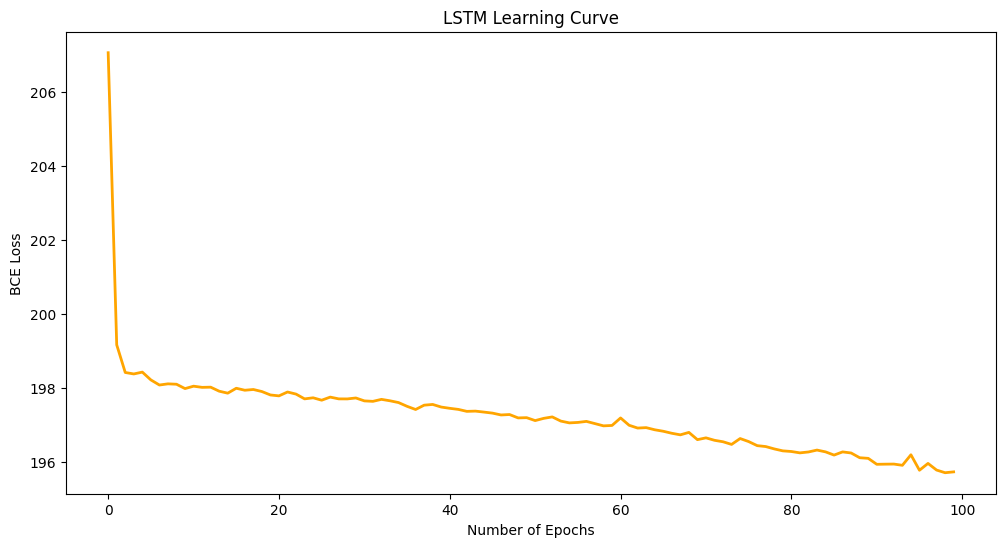

In [66]:
plt.figure(figsize=(12,6))
plt.plot(history_train_loss, color='orange', lw=2)
plt.xlabel("Number of Epochs")
plt.ylabel("BCE Loss")
plt.title("LSTM Learning Curve")

In [59]:
# binaralize the pay status each month and predict the default result
full_data = pd.read_csv("default of credit card clients.csv")
positive_mask = (full_data[['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0']] > 0)
full_data[['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0']] = positive_mask.astype(int)
full_data[['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0']] = full_data[['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0']].replace({False: 0})


In [60]:
time_series_binary_columns = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0', 'default payment next month']
time_series_binary_data = full_data[time_series_binary_columns]

X_time_series_binary = time_series_binary_data.iloc[:, :-1].values
y_time_series_binary = time_series_binary_data.iloc[:, -1].values

X_train_time_series_binary, X_test_time_series_binary, y_train_time_series_binary, y_test_time_series_binary = train_test_split(X_time_series_binary, y_time_series_binary, test_size=0.2, random_state=42)

In [61]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

X_train_time_series_binary = X_train_time_series_binary.reshape(X_train_time_series_binary.shape[0], X_train_time_series_binary.shape[1], 1)
X_test_time_series_binary = X_test_time_series_binary.reshape(X_test_time_series_binary.shape[0], X_test_time_series_binary.shape[1], 1)

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_time_series_binary.shape[1], X_train_time_series_binary.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_time_series_binary, y_train_time_series_binary, epochs=10, batch_size=32)

Epoch 1/10
750/750 [==============================] - 11s 12ms/step - loss: 0.4689 - accuracy: 0.8025
Epoch 2/10
750/750 [==============================] - 15s 20ms/step - loss: 0.4550 - accuracy: 0.8059
Epoch 3/10
750/750 [==============================] - 8s 11ms/step - loss: 0.4543 - accuracy: 0.8065
Epoch 4/10
750/750 [==============================] - 9s 12ms/step - loss: 0.4534 - accuracy: 0.8071
Epoch 5/10
750/750 [==============================] - 9s 12ms/step - loss: 0.4535 - accuracy: 0.8065
Epoch 6/10
750/750 [==============================] - 8s 10ms/step - loss: 0.4533 - accuracy: 0.8069
Epoch 7/10
750/750 [==============================] - 9s 12ms/step - loss: 0.4529 - accuracy: 0.8076
Epoch 8/10
750/750 [==============================] - 9s 12ms/step - loss: 0.4525 - accuracy: 0.8080
Epoch 9/10
750/750 [==============================] - 8s 10ms/step - loss: 0.4520 - accuracy: 0.8076
Epoch 10/10
750/750 [==============================] - 9s 12ms/step - loss: 0.4521 - accu

In [62]:
y_pred_prob = model.predict(X_test_time_series_binary)
y_pred = np.round(y_pred_prob)

auc_score = roc_auc_score(y_test_time_series_binary, y_pred_prob)

print("AUC Score:", auc_score)

188/188 [==============================] - 1s 5ms/step
AUC Score: 0.7272233435288188


In [63]:
loss, accuracy = model.evaluate(X_test_time_series_binary, y_test_time_series_binary)
print("Test Accuracy:", accuracy)

probabilities = model.predict(X_test_time_series_binary)

188/188 [==============================] - 2s 5ms/step - loss: 0.4504 - accuracy: 0.8090
Test Accuracy: 0.8090000152587891
188/188 [==============================] - 1s 6ms/step


In [64]:
probabilities

array([[0.12844977],
       [0.12844977],
       [0.12844977],
       ...,
       [0.18978699],
       [0.37327322],
       [0.21786559]], dtype=float32)

In [ ]:
time_series_data = pd.read_csv('default of credit card clients.csv')

time_series_columns = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0', 'default payment next month']
time_series_data = time_series_data[time_series_columns]

X_time_series = time_series_data.iloc[:, :-1].values
y_time_series = time_series_data.iloc[:, -1].values

X_train_time_series, X_test_time_series, y_train_time_series, y_test_time_series = train_test_split(X_time_series, y_time_series, test_size=0.2, random_state=42)

In [ ]:
X_train_time_series = X_train_time_series.reshape(X_train_time_series.shape[0], X_train_time_series.shape[1], 1)
X_test_time_series = X_test_time_series.reshape(X_test_time_series.shape[0], X_test_time_series.shape[1], 1)

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_time_series.shape[1], X_train_time_series.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_time_series, y_train_time_series, epochs=10, batch_size=32)


In [ ]:
X_train_time_series.shape[0]

In [ ]:
y_pred_prob = model.predict(X_test_time_series)
y_pred = np.round(y_pred_prob)

auc_score = roc_auc_score(y_test_time_series, y_pred_prob)

print("AUC Score:", auc_score)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_time_series, y_pred_prob)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


**What's the most important information for credit card company?**

In [ ]:
classification_data = pd.read_csv("default of credit card clients.csv")

In [ ]:
X = full_data['LIMIT_BAL']
y = full_data['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

fig_roc(model_gb2,X_train, X_test, y_train, y_test)

In [ ]:
X_april = full_data[['LIMIT_BAL', 'PAY_6','BILL_AMT6','PAY_AMT6']]
y_april = full_data['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X_april,
                                                   y_april,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
fig_roc(model_gb2,X_train, X_test, y_train, y_test)

In [ ]:
X_may = full_data[['LIMIT_BAL','PAY_5','BILL_AMT5','PAY_AMT5']]
y_may = full_data['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X_may,
                                                   y_may,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
fig_roc(model_gb2,X_train, X_test, y_train, y_test)

In [ ]:
X_JUNE = full_data[['LIMIT_BAL','PAY_4','BILL_AMT4','PAY_AMT4']]
y_JUNE = full_data['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X_JUNE,
                                                   y_JUNE,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
fig_roc(model_gb2,X_train, X_test, y_train, y_test)

In [ ]:
X_JULY = full_data[['LIMIT_BAL','PAY_3','BILL_AMT3','PAY_AMT3']]
y_JULY = full_data['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X_JULY,
                                                   y_JULY,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
fig_roc(model_gb2,X_train, X_test, y_train, y_test)

In [ ]:
X_AUGUST = full_data[['LIMIT_BAL','PAY_2','BILL_AMT2','PAY_AMT2']]
y_AUGUST = full_data['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X_AUGUST,
                                                   y_AUGUST,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
fig_roc(model_gb2,X_train, X_test, y_train, y_test)

In [ ]:
X_SEP = full_data[['PAY_0']]
y_SEP = full_data['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X_SEP,
                                                   y_SEP,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
fig_roc(model_gb2,X_train, X_test, y_train, y_test)

In [ ]:
sensitive_columns = ['SEX', 'MARRIAGE', 'AGE']
data_without_sensitive = classification_data.drop(sensitive_columns, axis = 1)

In [ ]:
mask_columns = ['PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
classification_data1 = data_without_sensitive.drop(mask_columns, axis=1)

In [ ]:
classification_X1 = classification_data1.drop(['default payment next month'], axis=1)
classification_y1 = classification_data["default payment next month"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(classification_X1,
                                                    classification_y1,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
mask_columns = ['PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
classification_data2 = data_without_sensitive.drop(mask_columns, axis=1)

In [ ]:
classification_X2 = classification_data2.drop(['default payment next month'], axis=1)
classification_y2 = classification_data["default payment next month"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(classification_X2,
                                                    classification_y2,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
mask_columns = ['PAY_4', 'PAY_5', 'PAY_6',
                   'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
classification_data3 = data_without_sensitive.drop(mask_columns, axis=1)

In [ ]:
classification_X3 = classification_data3.drop(['default payment next month'], axis=1)
classification_y3 = classification_data["default payment next month"]

X_train3, X_test3, y_train3, y_test3 = train_test_split(classification_X3,
                                                    classification_y3,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
mask_columns = ['PAY_5', 'PAY_6',
                   'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT5', 'PAY_AMT6']
classification_data4 = data_without_sensitive.drop(mask_columns, axis=1)

In [ ]:
classification_X4 = classification_data4.drop(['default payment next month'], axis=1)
classification_y4 = classification_data["default payment next month"]

X_train4, X_test4, y_train4, y_test4 = train_test_split(classification_X4,
                                                    classification_y4,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
mask_columns = ['PAY_6',
                   'BILL_AMT6',
                  'PAY_AMT6']
classification_data5 = data_without_sensitive.drop(mask_columns, axis=1)

In [ ]:
classification_X5 = classification_data4.drop(['default payment next month'], axis=1)
classification_y5 = classification_data["default payment next month"]

X_train5, X_test5, y_train5, y_test5 = train_test_split(classification_X5,
                                                    classification_y5,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
scores = []
dataset_names = []

# Iterate over the datasets
for i in range(1, 6):
    # Train the model on the current training dataset
    model_gb2.fit(eval(f'X_train{i}'), eval(f'y_train{i}'))

    # Calculate the score for the current test dataset
    score = model_gb2.score(eval(f'X_test{i}'), eval(f'y_test{i}'))

    # Append the score and dataset name to the respective lists
    scores.append(score)
    dataset_names.append(f'Dataset{i}')
    fig_roc(model_gb2,eval(f'X_train{i}'), eval(f'X_test{i}'), eval(f'y_train{i}'), eval(f'y_test{i}'))

# Print the scores and dataset names
for dataset_name, score in zip(dataset_names, scores):
    print(f'{dataset_name}: {score}')


In [ ]:
plt.figure(figsize=(10,5))

sns.distplot(X_testdf['GB_PROB_DEFAULT'], hist=True, kde=True, bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})


In [ ]:
X_testdf['RISK'] = pd.cut(X_testdf['GB_PROB_DEFAULT'], bins=[0.000, 0.200, 0.600,1.000], labels=['LOW_RISK','MEDIUM_RISK','HIGH_RISK'])

X_testdf['RISK'].value_counts()

In [ ]:
#Get count plots for risk by education.

f, axes = plt.subplots(2,2,figsize=(15, 10), facecolor='white',sharey=True)
f.suptitle('FREQUENCY OF EDUCATION (BY RISK)')
ax1 = sns.countplot(x="RISK", hue="graduate school", data=X_testdf, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="RISK", hue="high school", data=X_testdf, palette="Blues", ax=axes[0,1])
ax3 = sns.countplot(x="RISK", hue="university", data=X_testdf, palette="Blues", ax=axes[1,0])
ax4 = sns.countplot(x="RISK", hue="others", data=X_testdf, palette="Blues", ax=axes[1,1])

In [ ]:
value_counts = df['default payment next month'].value_counts()

# Create the bar chart
plt.bar(value_counts.index, value_counts.values)

# Set the labels and title
plt.xlabel('Binary Value (defaulters)')
plt.ylabel('Count')
plt.title('Bar Chart for defaulters and non-defaulters')

# Show the plot
plt.show()

In [ ]:
df1 = pd.DataFrame()
df1['PAY_1 || PAY_2'] = ((df['PAY_0'] == -1) | (df['PAY_2'] == -1)).astype(int)
df1['PAY_1 & PAY_2'] = ((df['PAY_0'] == -1) & (df['PAY_2'] == -1)).astype(int)
df1['default payment next month'] = df['default payment next month']
df1.head()

**Dimensionality Reduction with PCA**

In [ ]:
df = pd.read_csv("default of credit card clients.csv")
y = df['default payment next month']
X = df.drop('default payment next month', axis = 1, inplace = False)
X_train_val, X_test_reduced, y_train_val, y_test_reduced = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
from sklearn.decomposition import PCA

print(f"Actual number of components: {len(X_train_val.columns.values)}")

n_pc = len(X_train_val.columns.values)

pca = PCA(n_components=n_pc)
pca.fit(X_train_val)

fig=plt.figure(1, figsize=(10,5))
plt.grid(True, which='major', axis='both')
plt.plot(pca.explained_variance_ratio_, marker='o', color='#20c8b8')
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='#e8a000')

plt.legend(["Variance explained by a single component", "Cumulative variance explained"])
plt.xlabel('Number of principal components')
plt.ylabel('Variance Explained')
plt.savefig("PCA")

In [ ]:
n_pc = 12
pca = PCA(n_components=n_pc)
pca.fit(X_train_val)

X_12d_train = pd.DataFrame(pca.transform(X_train_val))
X_12d_test = pd.DataFrame(pca.transform(X_test_reduced))
X_12d_train.columns = ['PC' + str(i) for i in range(1, n_pc+1) ]
X_12d_test.columns = ['PC' + str(i) for i in range(1, n_pc+1) ]

In [ ]:
clf_rfgi_PCA=RandomForestClassifier(criterion='gini')
clf_rfgi_PCA.fit(X_12d_train,y_train_val)

In [ ]:
gb_clf_PCA=GradientBoostingClassifier()
gb_clf_PCA.fit(X_12d_train,y_train_val)

In [ ]:
print("Score of Random Forest Model with PCA on train: ","{0:.4f}".format(clf_rfgi_PCA.score(X_12d_train,y_train_val)))

In [ ]:
print("Score of Gradient Boosting Model with PCA on train: ","{0:.4f}".format(gb_clf_PCA.score(X_12d_train,y_train_val)))

In [ ]:
fig_roc(clf_rfgi_PCA, X_12d_train, X_12d_test, y_train_val, y_test_reduced)

In [ ]:
fig_roc(gb_clf_PCA, X_12d_train, X_12d_test, y_train_val, y_test_reduced)

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=12, n_neighbors=10)
X_reduced = lle.fit_transform(xs)

In [ ]:
clf_rfgi_lle=RandomForestClassifier(criterion='gini')
clf_rfgi_lle.fit(X_reduced,ys)

In [ ]:
gb_clf_lle=GradientBoostingClassifier()
gb_clf_lle.fit(X_reduced,ys)

In [ ]:
print("Score of Random Forest Model with LLE on train: ","{0:.4f}".format(clf_rfgi_lle.score(X_reduced,ys)))

In [ ]:
print("Score of Gradient Boosting Model with LLE on train: ","{0:.4f}".format(gb_clf_lle.score(X_reduced,ys)))

In [ ]:
fig_roc(clf_rfgi_lle, X_reduced, X_12d_test, ys, y_test_reduced)

In [ ]:
fig_roc(gb_clf_lle, X_reduced, X_12d_test, ys, y_test_reduced)